In [395]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [396]:
df_tick_data = pd.read_csv("../data/01102025/NIFTY-I.NFO.csv").set_index("Date")
df_tick_data

,Time,MID_PRICE,BID_SIZE,BID_PRICE,ASK_PRICE,ASK_SIZE
Date,,,,,,
2025-10-01,09:15:00.000,24748.15,75.0,24746.4,24749.9,150.0
2025-10-01,09:15:01.000,24749.65,75.0,24745.3,24754.0,1800.0
2025-10-01,09:15:02.000,24749.65,75.0,24745.3,24754.0,1800.0
2025-10-01,09:15:03.000,24750.90,75.0,24747.8,24754.0,525.0
2025-10-01,09:15:04.000,24752.60,375.0,24750.1,24755.1,75.0
...,...,...,...,...,...,...
2025-10-01,15:29:56.000,24977.50,1650.0,24977.2,24977.8,1350.0
2025-10-01,15:29:57.000,24977.55,75.0,24977.3,24977.8,1425.0
2025-10-01,15:29:58.000,24977.55,75.0,24977.3,24977.8,1425.0


In [397]:
df_futures = pd.read_csv("../data/NFO_Data/nifty25decfut/nifty25decfut_2025-10-01.csv").set_index("datetime")
print(df_futures.head())

                            timestamp     open     high      low    close  \
datetime                                                                    
2025-10-01 09:16:00+05:30  1759290300  24751.8  24769.0  24725.0  24758.0   
2025-10-01 09:17:00+05:30  1759290360  24758.3  24758.3  24743.1  24748.0   
2025-10-01 09:18:00+05:30  1759290420  24747.5  24765.0  24745.0  24760.7   
2025-10-01 09:19:00+05:30  1759290480  24765.0  24766.0  24755.3  24755.3   
2025-10-01 09:20:00+05:30  1759290540  24759.7  24759.7  24750.0  24750.0   

                           volume  
datetime                           
2025-10-01 09:16:00+05:30  111975  
2025-10-01 09:17:00+05:30   73650  
2025-10-01 09:18:00+05:30   34650  
2025-10-01 09:19:00+05:30   19275  
2025-10-01 09:20:00+05:30   17775  


#### Feature Engineering

In [398]:
# Ensure datetime index
df_tick_data['datetime'] = pd.to_datetime(df_tick_data.index.astype(str) + ' ' + df_tick_data['Time'].astype(str))
df_tick_data.set_index('datetime', inplace=True)
df_tick_data.sort_index(inplace=True)

# Calculate instantaneous imbalance at each second
df_tick_data['imbalance'] = (df_tick_data['BID_SIZE'] - df_tick_data['ASK_SIZE']) / (df_tick_data['BID_SIZE'] + df_tick_data['ASK_SIZE'])

# Aggregate to 1-minute
minute_features = df_tick_data.resample('1min').agg({
    'imbalance': ['mean', 'std', 'last']  # mean = avg control, std = volatility, last = ending state
}).round(6)

# Flatten column names
minute_features.columns = ['_'.join(col).strip() for col in minute_features.columns.values]
minute_features = minute_features.shift().dropna(how="all")

print(minute_features.head())

                     imbalance_mean  imbalance_std  imbalance_last
datetime                                                          
2025-10-01 09:16:00       -0.177098       0.455473       -0.200000
2025-10-01 09:17:00       -0.069999       0.567110        0.945946
2025-10-01 09:18:00        0.130642       0.500070        0.333333
2025-10-01 09:19:00       -0.097111       0.385865        0.750000
2025-10-01 09:20:00        0.052659       0.463237        0.925926


In [399]:
minute_features = minute_features.shift()
minute_features = minute_features.dropna(how="any")
print(minute_features.head())

                     imbalance_mean  imbalance_std  imbalance_last
datetime                                                          
2025-10-01 09:17:00       -0.177098       0.455473       -0.200000
2025-10-01 09:18:00       -0.069999       0.567110        0.945946
2025-10-01 09:19:00        0.130642       0.500070        0.333333
2025-10-01 09:20:00       -0.097111       0.385865        0.750000
2025-10-01 09:21:00        0.052659       0.463237        0.925926


In [400]:
df_futures["close_log_returns"] = np.log(df_futures["close"]/df_futures["close"].shift())

In [401]:
df_futures = df_futures.dropna(how="any")
print(df_futures.head())


                            timestamp     open     high      low    close  \
datetime                                                                    
2025-10-01 09:17:00+05:30  1759290360  24758.3  24758.3  24743.1  24748.0   
2025-10-01 09:18:00+05:30  1759290420  24747.5  24765.0  24745.0  24760.7   
2025-10-01 09:19:00+05:30  1759290480  24765.0  24766.0  24755.3  24755.3   
2025-10-01 09:20:00+05:30  1759290540  24759.7  24759.7  24750.0  24750.0   
2025-10-01 09:21:00+05:30  1759290600  24750.1  24752.6  24734.0  24752.6   

                           volume  close_log_returns  
datetime                                              
2025-10-01 09:17:00+05:30   73650          -0.000404  
2025-10-01 09:18:00+05:30   34650           0.000513  
2025-10-01 09:19:00+05:30   19275          -0.000218  
2025-10-01 09:20:00+05:30   17775          -0.000214  
2025-10-01 09:21:00+05:30   68625           0.000105  


In [402]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, classification_report, accuracy_score
from sklearn.model_selection import train_test_split

In [403]:
len(minute_features), len(df_futures["close"])

(374, 374)

In [404]:
y = (df_futures["close_log_returns"] > 0).astype(int)
y.value_counts()


close_log_returns
1    200
0    174
Name: count, dtype: int64

In [405]:
X_train, X_Test, y_train,y_test= train_test_split(minute_features,df_futures["close_log_returns"], test_size=0.2, shuffle=False)

In [406]:
X_train, X_Test, y_train,y_test= train_test_split(minute_features,y, test_size=0.2, shuffle=False)

In [407]:
model = LogisticRegression()
model.fit(X_train,y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [408]:
accuracy_score(y_train,model.predict(X_train))

0.5117056856187291

In [409]:
accuracy_score(y_test,model.predict(X_Test))

0.6

In [410]:
print(classification_report(y_test,model.predict(X_Test)))

              precision    recall  f1-score   support

           0       0.57      0.13      0.21        31
           1       0.60      0.93      0.73        44

    accuracy                           0.60        75
   macro avg       0.59      0.53      0.47        75
weighted avg       0.59      0.60      0.52        75



In [411]:
# Step 1: 60% train, 40% remaining
X_train, X_temp, y_train, y_temp = train_test_split(minute_features, y, test_size=0.4, shuffle=False)

# Step 2: Split 40% into 50/50 → each gets 20% of original
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

In [412]:
model = DecisionTreeClassifier(max_depth=5)

In [413]:
model.fit(X_train,y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [414]:
accuracy_score(y_train,model.predict(X_train))

0.5982142857142857

In [415]:
accuracy_score(y_test,model.predict(X_Test))

0.6

In [416]:
print(classification_report(y_test,model.predict(X_Test)))

              precision    recall  f1-score   support

           0       0.52      0.52      0.52        31
           1       0.66      0.66      0.66        44

    accuracy                           0.60        75
   macro avg       0.59      0.59      0.59        75
weighted avg       0.60      0.60      0.60        75



In [417]:
depth_hyperparams = range(1,50,2)

In [418]:
training_acc =  []
validation_acc = []
for d in depth_hyperparams:
    # Create model with `max_depth` of `d`
    test_model = DecisionTreeClassifier(random_state=42, max_depth=d)
        
    #Fit model to the training data
    test_model.fit(X_train, y_train)
    #Calculate training accuracy score and append to `training_acc`
    training_acc.append(test_model.score(X_train,y_train))
    #Calculate validation accuracy score and append to `validation_acc`
    validation_acc.append(test_model.score(X_val,y_val))

    print("Training Accuracy Scores:", training_acc[:3])
    print("Validation Accuracy Scores:", validation_acc[:3])


Training Accuracy Scores: [0.5223214285714286]
Validation Accuracy Scores: [0.52]
Training Accuracy Scores: [0.5223214285714286, 0.5491071428571429]
Validation Accuracy Scores: [0.52, 0.5333333333333333]
Training Accuracy Scores: [0.5223214285714286, 0.5491071428571429, 0.5982142857142857]
Validation Accuracy Scores: [0.52, 0.5333333333333333, 0.5866666666666667]
Training Accuracy Scores: [0.5223214285714286, 0.5491071428571429, 0.5982142857142857]
Validation Accuracy Scores: [0.52, 0.5333333333333333, 0.5866666666666667]
Training Accuracy Scores: [0.5223214285714286, 0.5491071428571429, 0.5982142857142857]
Validation Accuracy Scores: [0.52, 0.5333333333333333, 0.5866666666666667]
Training Accuracy Scores: [0.5223214285714286, 0.5491071428571429, 0.5982142857142857]
Validation Accuracy Scores: [0.52, 0.5333333333333333, 0.5866666666666667]
Training Accuracy Scores: [0.5223214285714286, 0.5491071428571429, 0.5982142857142857]
Validation Accuracy Scores: [0.52, 0.5333333333333333, 0.5866

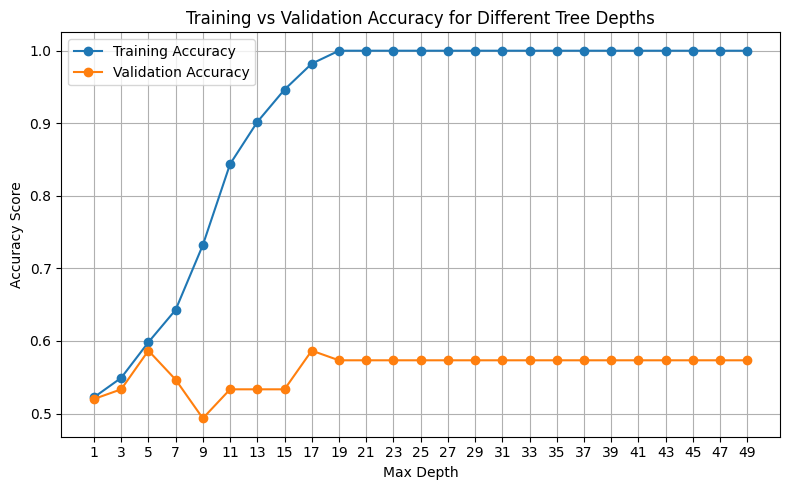

In [419]:
plt.figure(figsize=(8,5))

plt.plot(depth_hyperparams, training_acc, marker='o', label="Training Accuracy")
plt.plot(depth_hyperparams, validation_acc, marker='o', label="Validation Accuracy")


plt.xticks(depth_hyperparams)

plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.title("Training vs Validation Accuracy for Different Tree Depths")

plt.grid(True)  # Add grid
plt.legend()
plt.tight_layout()
plt.show()
